<img src="https://github.com/earthwave/eolis_demo_notebooks_binder/blob/main/cryotempo_logo.png?raw=1" alt="logo" width="200"/> <img src="https://github.com/earthwave/eolis_demo_notebooks_binder/blob/main/esa_logo.png?raw=1" alt="esa" width="170"/> <img src="https://github.com/earthwave/eolis_demo_notebooks_binder/blob/main/earthwave_logo.png?raw=1" alt="earthwave" width="150"/> <img src="https://github.com/earthwave/eolis_demo_notebooks_binder/blob/main/UoE_logo.png?raw=1" alt="uoe" width="200"/>

##<strong>*This is a Jupyter notebook that demonstrates how to download and use Cryotempo-EOLIS data, downloaded from cs2eo.org. Here, we will read in some gridded data and then plot DEMs*</strong>
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -

To run this notebook, you will need to make sure that the folllowing packages are installed in your python environment (all can be installed via pip/conda)

    - matplotlib
    - pandas: for dataframe manipulation
    - netCDF4: for handing NetCDF files
    - glob
    - datetime: for handling timestamps
    - numpy
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -

In [1]:
# !pip install netCDF4
# !pip install contextily

###<strong>1) Download Data:

Regardless of whether you are using the Google Colab environment, or have downloaded this notebook to your local drive, you will first need to download some data. You can use this notebook to plot any CryoTEMPO-EOLIS gridded data that you choose. For a quick example, follow the below instructions to download a small example dataset.</strong>

- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -

Imports necessary to run the rest of the code

In [2]:
import datetime
import glob
import os
from ftplib import FTP

import contextily as ctx
import geopandas as gp
import matplotlib.pyplot as plt
import netCDF4 as nc
import numpy as np
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from shapely import Polygon

plt.rcParams.update({'font.size': 14})

<strong>The following four cells contain the python script necessary to download the results of the query described above from the ESA FTP servers. It is taken verbatim from the script generated by a cs2eo query - one could run said script in place of these 4 cells, for any query of your choice. The data is downloaded to your current working directory. This query will download a file containing gridded product data for Iceland.</strong>

This function is necessary to complete the data download

In [3]:
def file_byte_handler(data):
    global download_file_obj, read_byte_count, total_byte_count
    download_file_obj.write(data)
    read_byte_count = read_byte_count + len(data)

First, we list the files that we want to download. These are generated automatically by a [cs2eo.org](https://cs2eo.org/cryotempo) query. If you wanted to download additional months or a different region, you would add the corresponding file paths to this list.

In [4]:
esa_files =  ['/TEMPO_SWATH_GRID/2021/06/ANTARCTIC/CS_OFFL_THEM_GRID__ANTARCTIC___2021_06_V201.nc']
download_file_obj = None
read_byte_count = None
total_byte_count = None

Next, we must provide an email address to access the ESA FTP server. Input your email into the prompt that appears below.

In [5]:
email = "tyler.petillion@gmail.com"

Finally, we connect to the server, supply our email address and download the data to our current working directory. This process should take a couple of minutes. The progress of the download will be shown below.

In [6]:
# print("About to connect to ESA science server")
# # Open the FTP connection
# with FTP("science-pds.cryosat.esa.int") as ftp:
#     try:
#         #Login using your email address
#         ftp.login("anonymous", email)
#         print("Downloading {} files".format(len(esa_files)))
#         # Step through the files that we want to download
#         for i, filename in enumerate(esa_files):
#             padded_count = str(i+1).zfill(len(str(len(esa_files))))
#             # Print some details about the progress of the download
#             print("{}/{}. Downloading file {}".format(padded_count, len(esa_files), os.path.basename(filename)))
#             with open(os.path.basename(filename), 'wb') as download_file:
#                 download_file_obj = download_file
#                 total_byte_count = ftp.size(filename)
#                 read_byte_count = 0
#                 ftp.retrbinary('RETR ' + filename, file_byte_handler, 1024)
#             print("\n")
#     # After downloading all of the files, close the FTP connection
#     finally:
#         print("Exiting FTP.")
#         ftp.quit()

- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
###<strong>2) Load downloaded data into python</strong>

<strong>Now that we have downloaded the data, we can use python to visualise it. In the remainder of this demo notebook, we will load the data that we have just downloaded into python, and then use it to plot a series of DEMs showing the elevation of the Vatnajokull glacier.</strong>

If you have downloaded the notebook onto your local machine, you will need to edit the filepath below to point to the location of the downloaded data. We will then locate and store the names of each of the gridded data files. The gridded data is stored in *netcdf* files, which have the suffix '.nc'.
Here, we also define the coordinate reference system (CRS) for the region that we are plotting (Iceland), that describes the projection information for this geographical area. If you wish to plot a different region, you may need to change the CRS definition to match the region, as described at https://cryotempo-eolis.org/products/

In [7]:
region = 'ANTARCTIC'
data_filepath = '../data/grid_data' #Filepath specific to the Google Colab environment - edit this is you are running the notebook on your local system
files = sorted(glob.glob(data_filepath+f'/*{region}*.nc')) # If you download data for a different region, edit the name provided here

<strong>Now that the files containing the data have been located, we will load the data that they contain into python, one file at a time.</strong>

In [8]:
dem_list, timestamp_list = [], []

Firstly, we can check the metadata for the gridded product files. In the output of this command, we can see lots of additional information assosciated with the gridded product files, including projection information, product version and support information.

In [9]:
dataset = nc.Dataset(files[0])
print(dataset)

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    cdm_data_type: Gridded
    Conventions: CF-1.7
    Metadata_Conventions: Unidata Dataset Discovery v1.0
    contact: support@cryotempo-eolis.org
    creator_email: support@cryotempo-eolis.org
    creator_url: http://cryotempo-eolis.org/
    date_created: 2023-06-29T17:50:40.718642
    date_modified: 2023-06-29T17:50:40.718667
    DOI: 10.5270/CR2-2xs4q4l
    title: CryoTEMPO-EOLIS Thematic Gridded Product
    comment: CryoTEMPO-EOLIS: Elevation Over Land Ice from Swath. Gridded product containing elevation estimates on a regular grid
    region: antarctic
    baseline: 2
    summary: CryoTEMPO-EOLIS: Elevation Over Land Ice from Swath. Gridded product containing elevation estimates on a regular grid
    version: 1
    geospatial_y_min: -2400000
    geospatial_y_max: 2300000
    geospatial_x_min: -2700000
    geospatial_x_max: 2800000
    geospatial_y_units: metres
    geospatial_x_units: metres
  

We can extract the coordinate projection information from the metadata

In [10]:
proj4_code = dataset.geospatial_projection[1:-1]
proj4_code

'proj=stere +lat_0=-90 +lat_ts=-71 +lon_0=0 +k=1 +x_0=0 +y_0=0 +datum=WGS84 +units=m +no_def'

 The following loop opens each netcdf file, reads in the data associated with each variable, and stores this data in the column of a dataframe. Here we choose to extract the x and y positions, and the elevation value, of each gridcell within the gridded product.

In [11]:
for i in range(len(files)):
    # Open the netcdf file
    netcdf = nc.Dataset(files[i])

    # Load data from the file
    time =  netcdf.variables['time']
    timestamp_list.append(time[:])
    dem_array = netcdf.variables['elevation'][:]
    gridcell_x_bounds = netcdf.variables['x_bnds'][:]
    gridcell_y_bounds = netcdf.variables['y_bnds'][:]

    # create polygon objects for each gridcell in the DEM
    gridcell_polygons = []
    for x_bound in gridcell_x_bounds:
        for y_bound in gridcell_y_bounds:
            gridcell_polygons.append(Polygon(((x_bound[0], y_bound[0]),
                                              (x_bound[0], y_bound[1]),
                                              (x_bound[1], y_bound[1]),
                                              (x_bound[1], y_bound[0]))))
    # Set no data values to np.nan
    dem_array[dem_array.mask] = np.nan
    # x_bnds and y_bnds contain the boundaries of each gridcell - here we find the midpoint
    xs = np.average(gridcell_x_bounds.data, axis=1)
    ys = np.average(gridcell_y_bounds.data, axis=1)
    # Create a grid of x and y coordinates
    yy, xx = np.meshgrid(ys, xs)

    df = gp.GeoDataFrame({'x': xx.flatten(), 'y': yy.flatten(), 'elevation': dem_array.data.reshape(len(xs), len(ys)).flatten()},
                         geometry=gridcell_polygons, crs=proj4_code)

    dem_list.append(df)

Finally, we use the datetime python package to convert the *timestamps* provided by the EOLIS data into *years, months and days*.

In [12]:
dates = [datetime.datetime.fromtimestamp(a[0]) for a in timestamp_list]

- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
###<strong>3) Use the Cryotempo-EOLIS gridded product to plot a selection of DEMS, and show the difference in elevation for a specific time window</strong>

Below, we plot the 2-dimensional elevation data for the Vatnajokull glacier.

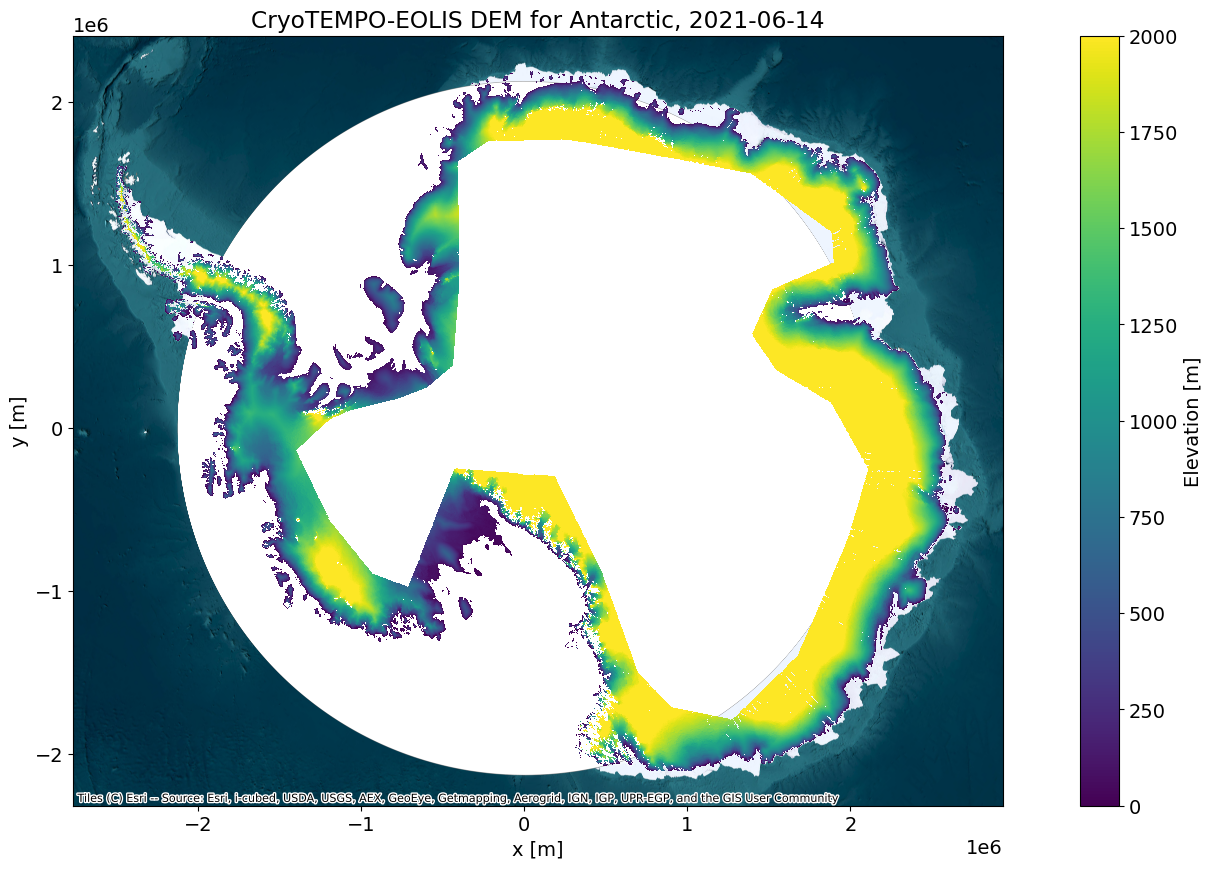

In [14]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20, 10))
dem_list[0].plot(column='elevation', ax=ax, cmap='viridis', vmin=0, vmax=2000, legend=True, legend_kwds={'label': 'Elevation [m]'})
ax.set_xlabel('x [m]')
ax.set_ylabel('y [m]')

plt.title(f'CryoTEMPO-EOLIS DEM for {region.title()}, {str(dates[0].date())}')

# set high resolution background map for zoomed in plot of Vatnajokull
ctx.add_basemap(ax,source=ctx.providers.Esri.WorldImagery, zoom=5, crs=proj4_code)

# add thumbnail to corner of plot to show where the data is
# thumbnail_ax = inset_axes(ax, width="25%", height=1.5, loc='upper left')

# set extent of iceland for second axis in EPSG:3413
# thumbnail_ax.set_ylim(-2700000, -2200000)
# thumbnail_ax.set_xlim(900000, 1500000)
# thumbnail_ax.tick_params(bottom=False, left=False, labelbottom=False, labelleft=False)
# for spine in ['bottom', 'top', 'right', 'left']:
#     thumbnail_ax.spines[spine].set_color('red')

# dem_list[0].plot(column='elevation', ax=thumbnail_ax, cmap='viridis', vmin=0, vmax=2000, legend=False)
# set lower resolution background map for zoomed out plot of iceland
# ctx.add_basemap(thumbnail_ax, source=ctx.providers.Esri.WorldImagery, zoom=3, crs=proj4_code, attribution=False)